# Homework 2
### Alex Pine
### akp258@nyu.edu

# Data preprocessing

I tokenized the data by splitting on whitespace. I left in strings of punctutation. I found the top 10,000 most frequently occuring words, and replaced all the words that didn't fall into that group with "<oov>". I then wrote code to replace each word with its vocabulary index position, and to pad each review with zeros to the maximum sequence length.

To determine an appropriate sequence length, I made a histogram of the length of the reviews (see below). From this histogram, I decided a maximum length of 700 words per review would be enough for classification.

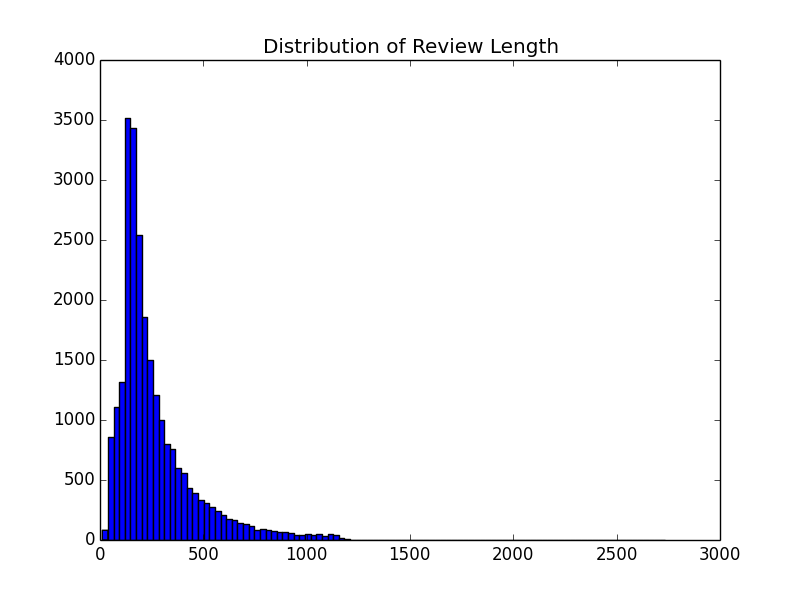

In [2]:
from IPython.display import Image
Image(filename='/Users/pinesol/nlp/hw2/review_len_dist.png') 

### Problem 1 - CBOW Unigram
Parameters:


- BATCH_SIZE=32
- EMBEDDING_DIM=64
- SEQUENCE_LENGTH=700
- LEARNING_RATE=0.001
- NUM_EPOCHS=15


Seems to work, but it is very noisy.

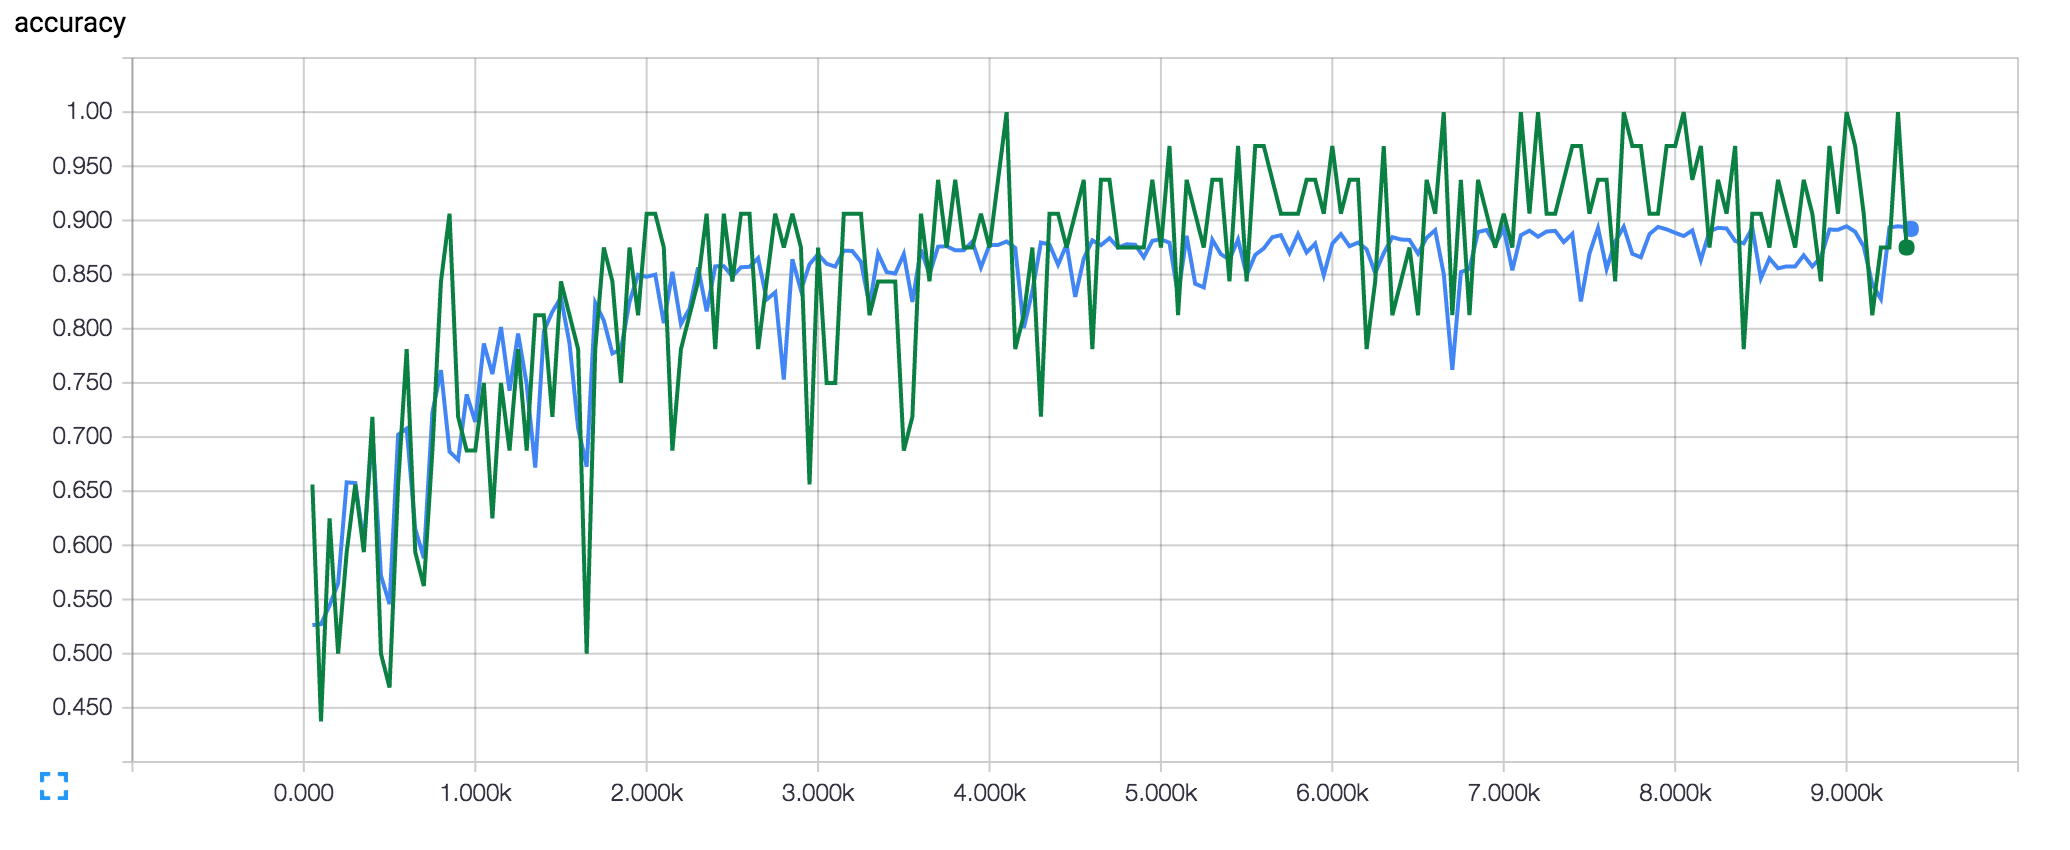

In [3]:
Image(filename='/Users/pinesol/nlp/hw2/first-run-accuracy.png') 

In [7]:
# TODO more experiments. smaller embedding maybe? smaller learning rate?


## Bigrams

I modified each review to include its bigrams in addition to its unigrams, but only if the bigram was one of the top 10,000 most frequently occuring bigrams. This brought the vocabulary size up to 20,000. I only chose to add the 1

Since each review became a little longer from the new bigrams, I increased the sequence length up to 800 from 700 to accommodate the new words.


- BATCH_SIZE=32
- EMBEDDING_DIM=64
- EVALUATE_EVERY=100
- EXP_NAME=bigrams
- LEARNING_RATE=0.001
- NUM_EPOCHS=15
- SEQUENCE_LENGTH=800

### Results
Unfortunately, there doesn't seem to be much of a difference between the unigram model and the bigram model. The extra bigrams simply don't add enough new information to significantly improve accuracy. 

Note that I did not graph every training timestep here, for readability.

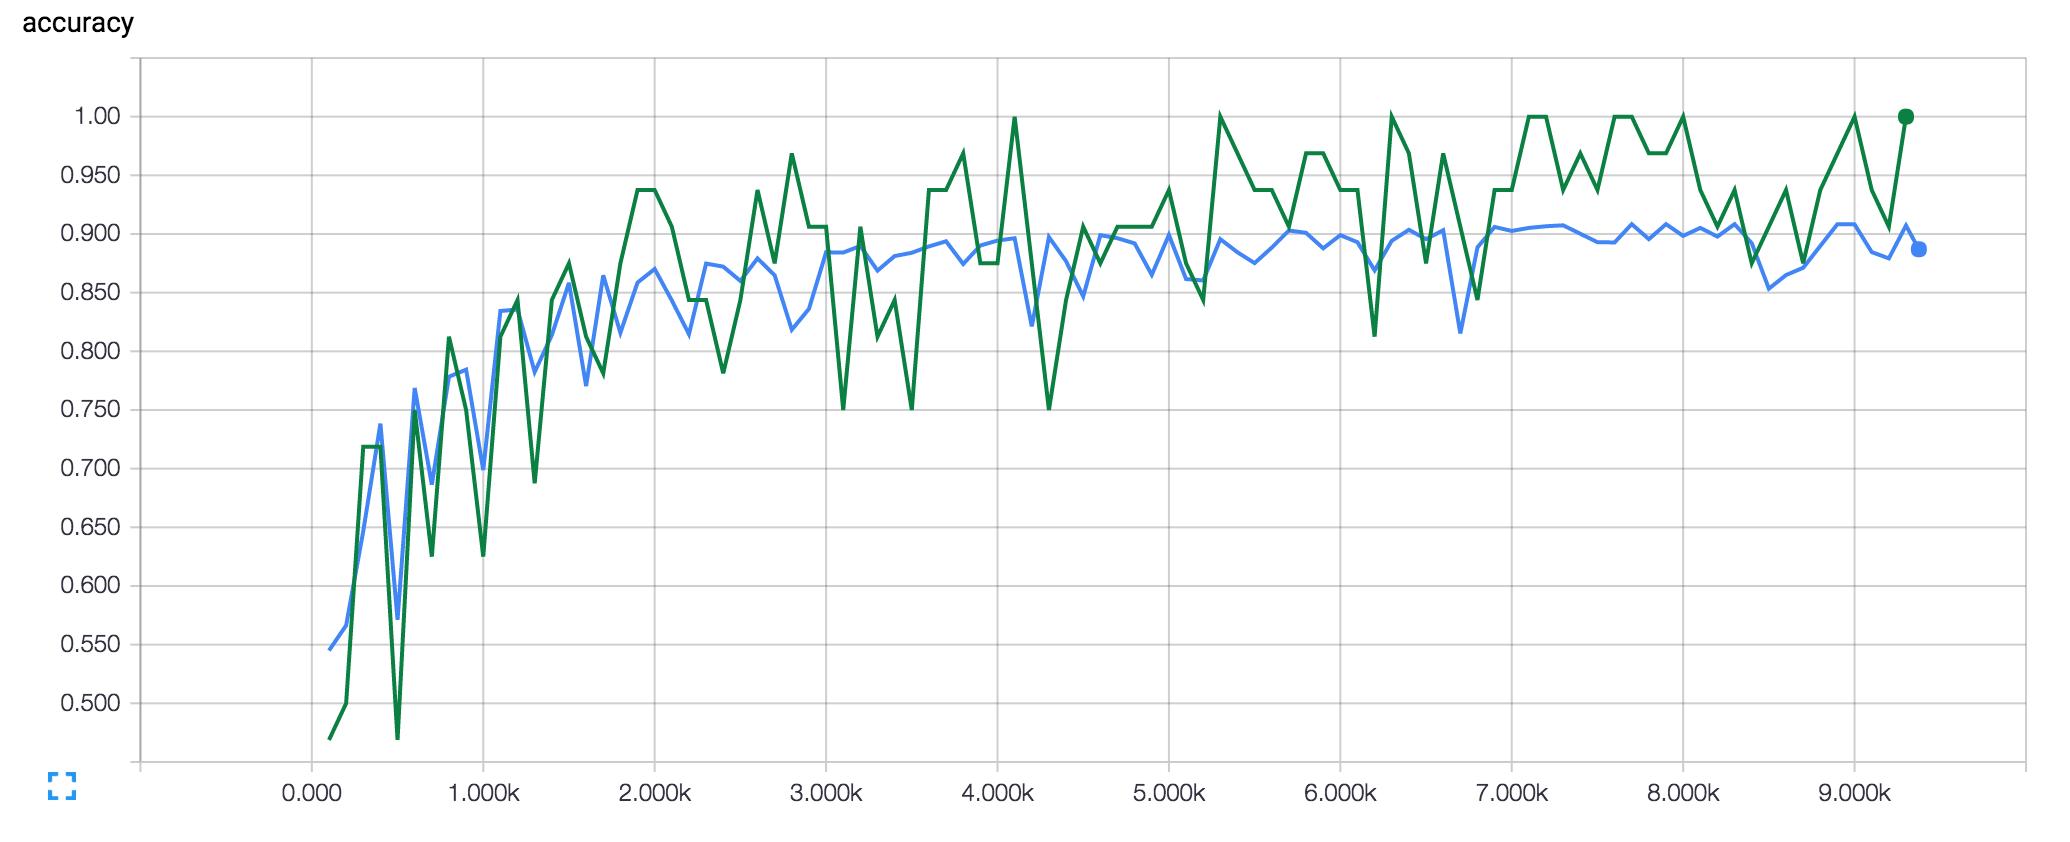

In [6]:
Image(filename='/Users/pinesol/nlp/hw2/bigram-accuracy.png') 